# IoT Intrusion Detection

The N-BaIoT Dataset contains traffic data for 9 IoT devices. The data comprise of both benign traffic and of a variety of malicious attacks. Here we run three deep neural networks to identify cyberattacks on a Provision PT-737E Security Camera.

In [ ]:
#import packages
import numpy as np  # linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
#from imutils import paths
import random
import pickle
import cv2
import datetime
from pprint import pprint
import librosa


from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *

import keras
from keras.utils import np_utils
from keras.regularizers import *
from keras.initializers import glorot_uniform

import keras.backend as K
K.clear_session()

from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import *

Data Importing - 10 datasets of both Benign and Botnet devices

In [2]:
benign=pd.read_csv('../input/nbaiot-dataset/5.benign.csv')
g_c=pd.read_csv('../input/nbaiot-dataset/5.gafgyt.combo.csv')
g_j=pd.read_csv('../input/nbaiot-dataset/5.gafgyt.junk.csv')
g_s=pd.read_csv('../input/nbaiot-dataset/5.gafgyt.scan.csv')
g_t=pd.read_csv('../input/nbaiot-dataset/5.gafgyt.tcp.csv')
g_u=pd.read_csv('../input/nbaiot-dataset/5.gafgyt.udp.csv')
m_a=pd.read_csv('../input/nbaiot-dataset/5.mirai.ack.csv')
m_sc=pd.read_csv('../input/nbaiot-dataset/5.mirai.scan.csv')
m_sy=pd.read_csv('../input/nbaiot-dataset/5.mirai.syn.csv')
m_u=pd.read_csv('../input/nbaiot-dataset/5.mirai.udp.csv')
m_u_p=pd.read_csv('../input/nbaiot-dataset/5.mirai.udpplain.csv')

'''
benign=benign.sample(frac=0.25,replace=False)
g_c=g_c.sample(frac=0.25,replace=False)
g_j=g_j.sample(frac=0.5,replace=False)
g_s=g_s.sample(frac=0.5,replace=False)
g_t=g_t.sample(frac=0.15,replace=False)
g_u=g_u.sample(frac=0.15,replace=False)
m_a=m_a.sample(frac=0.25,replace=False)
m_sc=m_sc.sample(frac=0.15,replace=False)
m_sy=m_sy.sample(frac=0.25,replace=False)
m_u=m_u.sample(frac=0.1,replace=False)
m_u_p=m_u_p.sample(frac=0.27,replace=False)
'''

benign['type']='benign'
m_u['type']='mirai_udp'
g_c['type']='gafgyt_combo'
g_j['type']='gafgyt_junk'
g_s['type']='gafgyt_scan'
g_t['type']='gafgyt_tcp'
g_u['type']='gafgyt_udp'
m_a['type']='mirai_ack'
m_sc['type']='mirai_scan'
m_sy['type']='mirai_syn'
m_u_p['type']='mirai_udpplain'

data=pd.concat([benign,m_u,g_c,g_j,g_s,g_t,g_u,m_a,m_sc,m_sy,m_u_p],
               axis=0, sort=False, ignore_index=True)

In [3]:
data.groupby('type')['type'].count()

type
benign             62154
gafgyt_combo       61380
gafgyt_junk        30898
gafgyt_scan        29297
gafgyt_tcp        104510
gafgyt_udp        104011
mirai_ack          60554
mirai_scan         96781
mirai_syn          65746
mirai_udp         156248
mirai_udpplain     56681
Name: type, dtype: int64

In [4]:
sampler=np.random.permutation(len(data))
data=data.take(sampler)
data

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,type
67536,113.198668,378.887114,55832.535694,182.847434,379.416561,5.574927e+04,542.615688,362.704022,57887.391335,3407.647921,...,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0,mirai_udp
123526,69.677883,446.934929,41365.024399,121.490775,386.808980,5.458018e+04,394.952108,343.855062,59610.409365,3962.864380,...,0.0,0.0,1.000000,554.0,0.000000,554.0,0.000000e+00,0.0,0.0,mirai_udp
36046,1.000000,72.000000,0.000000,1.000000,72.000000,0.000000e+00,1.000010,72.000027,0.002406,3.602238,...,0.0,0.0,1.000000,72.0,0.000000,72.0,0.000000e+00,0.0,0.0,benign
826434,67.094289,512.578698,18719.838165,96.121450,455.520566,3.891247e+04,284.131916,346.035096,59456.024926,3145.019842,...,0.0,0.0,12970.049521,554.0,0.000048,554.0,2.328306e-09,0.0,0.0,mirai_udpplain
378571,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0,gafgyt_tcp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694531,111.514388,60.045137,0.539701,137.420902,60.053108,6.394833e-01,266.002955,60.066736,0.977023,2071.476979,...,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0,mirai_scan
390859,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0,gafgyt_tcp
596437,106.275222,475.525742,37558.136681,159.419843,429.315364,5.044973e+04,421.207586,356.685444,62078.028574,3235.569911,...,0.0,0.0,1.000000,566.0,0.000000,566.0,0.000000e+00,0.0,0.0,mirai_ack
43840,1.000000,73.000000,0.000000,1.000000,73.000000,9.090000e-13,1.000028,72.999712,0.004942,2.198662,...,0.0,0.0,1.000000,73.0,0.000000,73.0,0.000000e+00,0.0,0.0,benign


In [5]:
#dummy encode labels, store separately
labels_full=pd.get_dummies(data['type'], prefix='type')
labels_full.head()

,type_benign,type_gafgyt_combo,type_gafgyt_junk,type_gafgyt_scan,type_gafgyt_tcp,type_gafgyt_udp,type_mirai_ack,type_mirai_scan,type_mirai_syn,type_mirai_udp,type_mirai_udpplain
67536,0,0,0,0,0,0,0,0,0,1,0
123526,0,0,0,0,0,0,0,0,0,1,0
36046,1,0,0,0,0,0,0,0,0,0,0
826434,0,0,0,0,0,0,0,0,0,0,1
378571,0,0,0,0,1,0,0,0,0,0,0


In [6]:
#drop labels from training dataset
data=data.drop(columns='type')
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
67536,113.198668,378.887114,55832.535694,182.847434,379.416561,55749.266852,542.615688,362.704022,57887.391335,3407.647921,...,0.000000e+00,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0
123526,69.677883,446.934929,41365.024399,121.490775,386.808980,54580.182354,394.952108,343.855062,59610.409365,3962.864380,...,0.000000e+00,0.0,0.0,1.000000,554.0,0.000000,554.0,0.000000e+00,0.0,0.0
36046,1.000000,72.000000,0.000000,1.000000,72.000000,0.000000,1.000010,72.000027,0.002406,3.602238,...,0.000000e+00,0.0,0.0,1.000000,72.0,0.000000,72.0,0.000000e+00,0.0,0.0
826434,67.094289,512.578698,18719.838165,96.121450,455.520566,38912.471403,284.131916,346.035096,59456.024926,3145.019842,...,8.731149e-10,0.0,0.0,12970.049521,554.0,0.000048,554.0,2.328306e-09,0.0,0.0
378571,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,0.0,1.000000,60.0,0.000000,60.0,0.000000e+00,0.0,0.0


In [7]:
#standardize numerical columns
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/df[col].std()

data_st=data.copy()
for i in (data_st.iloc[:,:-1].columns):
    standardize (data_st,i)

data_st.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
67536,0.744375,1.594305,1.589150,0.840209,1.674124,1.417246,1.033531,1.621630,1.343757,0.437938,...,-0.088211,-0.086932,-0.062471,-0.171718,-0.503039,-0.114248,-0.519127,-0.08798,-0.085239,0.0
123526,0.038384,2.077951,1.001306,0.194543,1.729201,1.372719,0.456932,1.474378,1.405315,0.692042,...,-0.088211,-0.086932,-0.062471,-0.171718,2.098895,-0.114248,2.068381,-0.08798,-0.085239,0.0
36046,-1.075703,-0.586875,-0.679439,-1.073401,-0.616288,-0.706091,-1.081377,-0.649420,-0.724389,-1.119975,...,-0.088211,-0.086932,-0.062471,-0.171718,-0.439834,-0.114248,-0.456273,-0.08798,-0.085239,0.0
826434,-0.003526,2.544509,0.081186,-0.072423,2.241138,0.775978,0.024200,1.491409,1.399799,0.317743,...,-0.088211,-0.086932,-0.062471,7.548802,2.098895,-0.114246,2.068381,-0.08798,-0.085239,0.0
378571,-1.075703,-0.672164,-0.679439,-1.073401,-0.705695,-0.706091,-1.081377,-0.743168,-0.724389,-1.121166,...,-0.088211,-0.086932,-0.062471,-0.171718,-0.503039,-0.114248,-0.519127,-0.08798,-0.085239,0.0


Data Training - Neural Net

In [8]:
train_data_st=data_st.values
train_data_st

array([[ 0.74437548,  1.59430514,  1.58915008, ..., -0.08797958,
        -0.08523948,  0.        ],
       [ 0.0383844 ,  2.0779505 ,  1.0013057 , ..., -0.08797958,
        -0.08523948,  0.        ],
       [-1.07570335, -0.58687483, -0.67943931, ..., -0.08797958,
        -0.08523948,  0.        ],
       ...,
       [ 0.63206382,  2.28115782,  0.84662411, ..., -0.08797958,
        -0.08523948,  0.        ],
       [-1.07570335, -0.5797674 , -0.67943931, ..., -0.08797958,
        -0.08523948,  0.        ],
       [-1.07570335, -0.67216404, -0.67943931, ..., -0.08797958,
        -0.08523948,  0.        ]])

In [9]:
#labels for training
labels=labels_full.values
labels

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Data Validation

In [10]:
x_train, x_test, y_train, y_test = train_test_split(train_data_st, labels, test_size=0.2)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.125)

print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)

(579782, 115)
(165652, 115)
(82826, 115)


In [11]:
x_train_cnn = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_validate_cnn = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1],1))
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(x_validate_cnn.shape)

(579782, 115, 1)
(165652, 115, 1)
(82826, 115, 1)


1. ANN

In [12]:
model = Sequential()
model.add(Dense(10, input_dim=train_data_st.shape[1], activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(labels.shape[1],activation='softmax'))

modelName = 'ANN'
keras.utils.plot_model(model, './'+modelName+'_Archi.png',show_shapes=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1160      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_4 (Dense)              (None, 11)                22        
Total params: 2,043
Trainable params: 2,043
Non-trainable params: 0
_________________________________________________________________


2. CNN + LSTM

In [13]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', input_shape = (train_data_st.shape[1], 1)))
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='same'))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(labels.shape[1],activation='softmax'))

modelName = 'CNN+LSTM'
keras.utils.plot_model(model, './'+modelName+'_Archi.png',show_shapes=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 115, 64)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 115, 32)           10272     
_________________________________________________________________
lstm (LSTM)                  (None, 115, 32)           8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 115, 16)           3136      
_________________________________________________________________
flatten (Flatten)            (None, 1840)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               235648    
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

3. Deep residual 1DCNN model

In [14]:
inp = Input(shape=(train_data_st.shape[1], 1))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(labels.shape[1])(D2)
A7 = Activation("softmax")(D3)

model = Model(inputs=inp, outputs=A7)


keras.utils.plot_model(model, './Deep_residual_CNN_model.png', show_shapes=True)

modelName='Deep residual CNN'

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 115, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 111, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 111, 32)      5152        conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 32)      0           conv1d_3[0][0]                   
_______________________________________________________________________________________

In [15]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) 

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            lr=0.00001)
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

checkpoint = ModelCheckpoint('./'+modelName+'.h5',
                            monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

Epoch 1/100
1127/1132 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8235
Epoch 00001: val_loss improved from inf to 0.19856, saving model to ./Deep residual CNN.h5
1132/1132 [==============================] - 10s 8ms/step - loss: 0.3326 - accuracy: 0.8237 - val_loss: 0.1986 - val_accuracy: 0.8675
Epoch 2/100
1130/1132 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.8689
Epoch 00002: val_loss improved from 0.19856 to 0.19443, saving model to ./Deep residual CNN.h5
1132/1132 [==============================] - 9s 8ms/step - loss: 0.1982 - accuracy: 0.8689 - val_loss: 0.1944 - val_accuracy: 0.8681
Epoch 3/100
1128/1132 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.8705
Epoch 00003: val_loss improved from 0.19443 to 0.18327, saving model to ./Deep residual CNN.h5
1132/1132 [==============================] - 10s 8ms/step - loss: 0.1867 - accuracy: 0.8705 - val_loss: 0.1833 - val_accuracy: 0.8709
Epoch 4/100
1130/1132

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


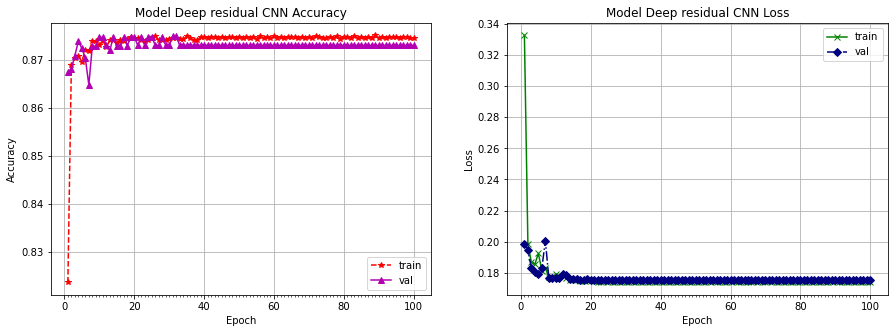

In [16]:
epochs = 100
batch_size = 512
history = model.fit(x_train_cnn,y_train, batch_size=batch_size,
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate_cnn,y_validate),
    #validation_split=0.10,
    callbacks=[learning_rate_reduction, checkpoint] 
)

#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1), model_history.history['accuracy'], '--*', color = (1,0,0))
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'], '-^', color = (0.7,0,0.7))
    axs[0].set_title('Model '+modelName+' Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid('on')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss'],'-x', color = (0,0.5,0))
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss'],  '-.D', color = (0,0,0.5))
    axs[1].set_title('Model '+modelName+' Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid('on')
    plt.savefig('./'+modelName+'.jpg',dpi=600, quality = 100, optimize = True)
    plt.show()

plot_model_history(history)
with open('./History_'+modelName, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


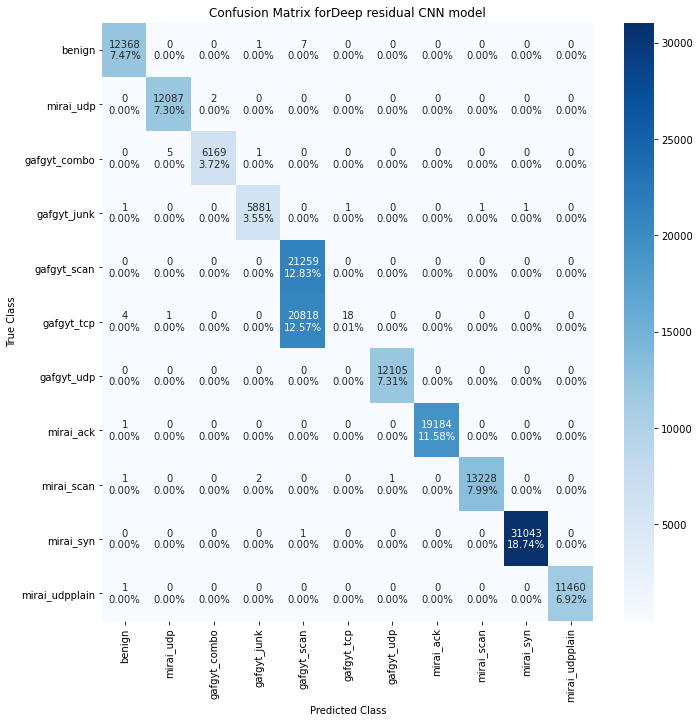

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 

y_pred = model.predict(x_test_cnn)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(11,11)

label = ['benign','mirai_udp','gafgyt_combo','gafgyt_junk','gafgyt_scan','gafgyt_tcp','gafgyt_udp'\
        ,'mirai_ack','mirai_scan','mirai_syn','mirai_udpplain']

plt.figure(figsize=(11,11))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [18]:
print(classification_report(y_test_cm, y_pred_cm, target_names= ['benign','mirai_udp','gafgyt_combo','gafgyt_junk','gafgyt_scan','gafgyt_tcp','gafgyt_udp','mirai_ack','mirai_scan','mirai_syn','mirai_udpplain']))

loss, accuracy = model.evaluate(x_test_cnn, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

with open('./'+modelName+'_CR.txt','a') as f:
    f.write(classification_report(y_test_cm, y_pred_cm, target_names= ['benign','mirai_udp','gafgyt_combo','gafgyt_junk','gafgyt_scan','gafgyt_tcp','gafgyt_udp','mirai_ack','mirai_scan','mirai_syn','mirai_udpplain']))
    f.write("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

                precision    recall  f1-score   support

        benign       1.00      1.00      1.00     12376
     mirai_udp       1.00      1.00      1.00     12089
  gafgyt_combo       1.00      1.00      1.00      6175
   gafgyt_junk       1.00      1.00      1.00      5885
   gafgyt_scan       0.51      1.00      0.67     21259
    gafgyt_tcp       0.95      0.00      0.00     20841
    gafgyt_udp       1.00      1.00      1.00     12105
     mirai_ack       1.00      1.00      1.00     19185
    mirai_scan       1.00      1.00      1.00     13232
     mirai_syn       1.00      1.00      1.00     31044
mirai_udpplain       1.00      1.00      1.00     11461

      accuracy                           0.87    165652
     macro avg       0.95      0.91      0.88    165652
  weighted avg       0.93      0.87      0.83    165652

5177/5177 [==============================] - 12s 2ms/step - loss: 0.1770 - accuracy: 0.8741
Test: accuracy = 0.874134  ;  loss = 0.177006


Plot Receiver Operating Characteristic (ROC)

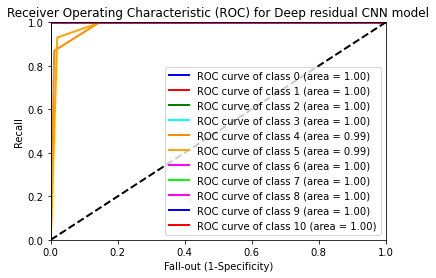

In [19]:
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','aqua', 'darkorange', 'orange','fuchsia', 'lime','magenta'])
for i, color in zip(range(labels.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.title('Receiver Operating Characteristic (ROC) for '+modelName+' model')
plt.legend(loc="lower right")
plt.savefig('./'+modelName+'_ROC.png')

plt.show()